# Intro
In the previous notebook, I did some basic exploration of the data, and fitted a model. The model was quite basic, and the metrics for the model were not the greatest.

In this notebook, I will explore the data further and attempt to improve the model.

I will try:

 - Data manipulations/different cleaning methods
 - Using cross-validation to better understand the model
 - Changing the parameters on the RandomForestClassifier model that I currently have.
 - [Maybe] Logistic Regression

 CV [here](https://www.askpython.com/python/examples/k-fold-cross-validation)

In [ ]:
# Upload data.csv
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from scipy import stats
from scipy.stats import norm

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,gameid,winning_team,100_TOP_avg_game_time,100_TOP_positions_played,100_TOP_avg_kda,100_TOP_avg_kp,100_TOP_avg_vision,100_TOP_avg_cs,100_TOP_goldpm,100_TOP_dmgpm,100_TOP_dmg_to_obj_pm,100_TOP_wr,100_TOP_tier,100_TOP_rank,100_TOP_lp,100_TOP_wins,100_TOP_losses,100_TOP_veteran,100_TOP_inactive,100_TOP_freshblood,100_TOP_hotstreak,100_TOP_role_total_played,100_TOP_role_wr,100_TOP_champ_games_played,100_TOP_champ_winrate,100_JUNGLE_avg_game_time,100_JUNGLE_positions_played,100_JUNGLE_avg_kda,100_JUNGLE_avg_kp,100_JUNGLE_avg_vision,100_JUNGLE_avg_cs,100_JUNGLE_goldpm,100_JUNGLE_dmgpm,100_JUNGLE_dmg_to_obj_pm,100_JUNGLE_wr,100_JUNGLE_tier,100_JUNGLE_rank,100_JUNGLE_lp,100_JUNGLE_wins,100_JUNGLE_losses,...,200_BOTTOM_goldpm,200_BOTTOM_dmgpm,200_BOTTOM_dmg_to_obj_pm,200_BOTTOM_wr,200_BOTTOM_tier,200_BOTTOM_rank,200_BOTTOM_lp,200_BOTTOM_wins,200_BOTTOM_losses,200_BOTTOM_veteran,200_BOTTOM_inactive,200_BOTTOM_freshblood,200_BOTTOM_hotstreak,200_BOTTOM_role_total_played,200_BOTTOM_role_wr,200_BOTTOM_champ_games_played,200_BOTTOM_champ_winrate,200_UTILITY_avg_game_time,200_UTILITY_positions_played,200_UTILITY_avg_kda,200_UTILITY_avg_kp,200_UTILITY_avg_vision,200_UTILITY_avg_cs,200_UTILITY_goldpm,200_UTILITY_dmgpm,200_UTILITY_dmg_to_obj_pm,200_UTILITY_wr,200_UTILITY_tier,200_UTILITY_rank,200_UTILITY_lp,200_UTILITY_wins,200_UTILITY_losses,200_UTILITY_veteran,200_UTILITY_inactive,200_UTILITY_freshblood,200_UTILITY_hotstreak,200_UTILITY_role_total_played,200_UTILITY_role_wr,200_UTILITY_champ_games_played,200_UTILITY_champ_winrate
0,NA1_4144890019,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.598333,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,6.859524,0.531200,19.2,5.322410,434.695953,580.689314,773.656332,0.5,CHALLENGER,I,1223,151,91,...,444.018576,727.816718,317.008050,0.8,GRANDMASTER,I,852,397,356,True,False,False,False,202,0.539604,36,0.555556,25.183333,BOTTOM BOTTOM BOTTOM BOTTOM UTILITY JUNGLE JUN...,3.513095,0.414308,37.1,5.102581,374.791529,439.441429,364.530774,0.4,GRANDMASTER,I,825,419,389,False,False,False,False,616,0.524351,25,0.360000
1,NA1_4142559007,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,22,0.500000,24.556667,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,5.588333,0.545225,20.6,7.452151,471.745622,768.023619,1009.444822,0.5,GRANDMASTER,I,493,148,112,...,482.375967,615.133624,140.509786,0.5,GRANDMASTER,I,495,424,380,True,False,False,False,35,0.714286,212,0.570755,28.300000,UTILITY UTILITY UTILITY UTILITY TOP JUNGLE UTI...,1.660960,0.506136,49.5,2.770318,326.858657,471.254417,135.872792,0.1,GRANDMASTER,I,651,592,507,False,False,False,False,941,0.547290,25,0.520000
2,NA1_4141413442,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.765000,JUNGLE JUNGLE JUNGLE TOP JUNGLE JUNGLE JUNGLE ...,3.637258,0.420519,20.1,7.317484,450.031559,643.980644,892.699348,0.4,GRANDMASTER,I,502,156,112,...,446.584003,666.117488,441.217850,0.4,GRANDMASTER,I,650,613,584,True,False,False,False,1024,0.515625,159,0.515723,27.480000,BOTTOM BOTTOM TOP BOTTOM BOTTOM BOTTOM BOTTOM ...,2.441634,0.507755,28.5,8.155022,502.503639,979.497817,501.419214,0.6,CHALLENGER,I,1387,417,349,True,False,False,False,28,0.500000,6,0.833333
3,NA1_4111370048,200,24.110000,MIDDLE TOP TOP TOP TOP TOP TOP TOP TOP TOP,1.912560,0.368992,16.5,6.744090,424.682704,688.888428,230.514309,0.4,CHALLENGER,I,1032,719,666,True,False,False,False,1130,0.535398,33,0.575758,26.801667,MIDDLE MIDDLE TOP MIDDLE JUNGLE MIDDLE MIDDLE ...,3.301111,0.386141,19.0,6.395125,418.854549,655.959207,285.068093,0.6,CHALLENGER,I,897,201,150,...,404.009017,649.48

# Looking at example NA value

200_BOTTOM_champ_winrate had a lot of NA values.

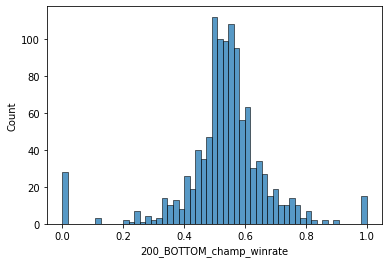

In [ ]:
sns.histplot(df["200_BOTTOM_champ_winrate"])

My hunch is that when you have 0% or 100% winrate, you probably have really few games played on a specific champion. I will look at that, and try making different decisions.

In [ ]:
temp_df = df[["200_BOTTOM_champ_winrate", "200_BOTTOM_champ_games_played"]]
temp_df[df["200_BOTTOM_champ_winrate"] > 0.99].sort_values(by="200_BOTTOM_champ_games_played", ascending=False)

,200_BOTTOM_champ_winrate,200_BOTTOM_champ_games_played
523,1.0,3
76,1.0,2
157,1.0,2
166,1.0,2
175,1.0,2
440,1.0,2
549,1.0,2
564,1.0,2
808,1.0,2
1199,1.0,2


In [ ]:
temp_df = df[["200_BOTTOM_champ_winrate", "200_BOTTOM_champ_games_played"]]
temp_df[df["200_BOTTOM_champ_winrate"] < 0.01].sort_values(by="200_BOTTOM_champ_games_played", ascending=False)

,200_BOTTOM_champ_winrate,200_BOTTOM_champ_games_played
783,0.0,4
1184,0.0,3
544,0.0,2
989,0.0,2
926,0.0,2
820,0.0,2
810,0.0,2
710,0.0,2
577,0.0,2
14,0.0,2


In [ ]:
temp_df = df[["200_BOTTOM_champ_winrate", "200_BOTTOM_champ_games_played", "winning_team"]]
temp_df = temp_df[df["200_BOTTOM_champ_winrate"] > 0.99]
temp_df["winning_team"].value_counts()

200    15
Name: winning_team, dtype: int64

In [ ]:
temp_df = df[["200_BOTTOM_champ_winrate", "200_BOTTOM_champ_games_played", "winning_team"]]
temp_df = temp_df[df["200_BOTTOM_champ_winrate"] < 0.01]
temp_df["winning_team"].value_counts()

100    28
Name: winning_team, dtype: int64

In [ ]:
temp_df = df[["200_BOTTOM_champ_winrate", "200_BOTTOM_champ_games_played", "winning_team"]]
temp_df = temp_df[df["200_BOTTOM_champ_winrate"].isnull()]
temp_df["winning_team"].value_counts()

100    82
200    72
Name: winning_team, dtype: int64

It seems that when a player has a high champion winrate they only win their games. Also if they have low winrate they're likely to lose as well.

### Reasoning

However, this is most likely because we collected data after the game gets played.

For example, if a person played 1 game with a champion, and won, and we collected the statistics after the fact, then it will say they have 1 game played on that champion, with a 100% winrate(which is the game we are scraping)

Therefore, it would be reasonable to try dealing with outliers by setting champ_wr values for a player to either:

 - The mean of champ_wr
 - 50%(theoretical probability of winning a League game)
 - Their ranked winrate(in which we will have to make a new variable wr that is wins/wins+losses)

# Dealing with NA values

I'm going to fill them with mean values for now.

I will prioritize feature selection/engineering

In [ ]:
# NA Values
a = df.isnull().sum(axis=0)

na_count = total = a.sort_values(ascending=False)

na_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([na_count, na_percent], axis=1, keys=["Total", "Percent"])

missing_data.head(20)

,Total,Percent
200_BOTTOM_champ_winrate,154,0.1232
100_BOTTOM_champ_winrate,149,0.1192
200_JUNGLE_champ_winrate,86,0.0688
100_JUNGLE_champ_winrate,80,0.0640
100_TOP_champ_winrate,47,0.0376
200_TOP_champ_winrate,39,0.0312
200_MIDDLE_champ_winrate,18,0.0144
100_MIDDLE_champ_winrate,11,0.0088
200_UTILITY_champ_winrate,7,0.0056
100_UTILITY_champ_winrate,4,0.0032


In [ ]:
df.fillna(df.mean(), inplace=True)

df.isnull().sum(axis=0).sort_values(ascending=False)

200_UTILITY_champ_winrate      0
100_BOTTOM_positions_played    0
100_BOTTOM_wins                0
100_BOTTOM_lp                  0
100_BOTTOM_rank                0
                              ..
200_JUNGLE_tier                0
200_JUNGLE_wr                  0
200_JUNGLE_dmg_to_obj_pm       0
200_JUNGLE_dmgpm               0
gameid                         0
Length: 232, dtype: int64

# Feature Engineering

My knowledge of feature engineering is rudimentary at best. I know how to perform transformations on data, and not much else. My attempt at feature engineering did not result in much.

I plan(ned) to go through:
 - all champ winrates(champ_winrate)
 - all ranked wr(wr)

Some other things I will probably look at, but are less important
 - lp(lp)
 - average kda across past 10 games(avg_kda)

## Champ winrates

It seems like most champ winrates have a similar distribution.

I considered many transformations for normality, but none of them really worked.

In addition, since I am not doing linear regression, there isn't an assumption that data should be normally distributed(if I'm correct). Sources also tell me that non-normal data doesn't affect the accuracy of a classification model too much.

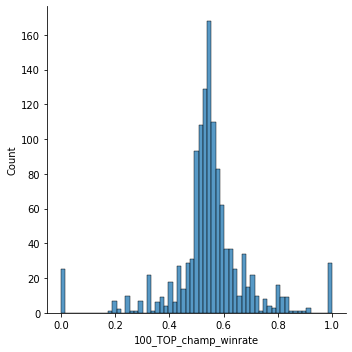

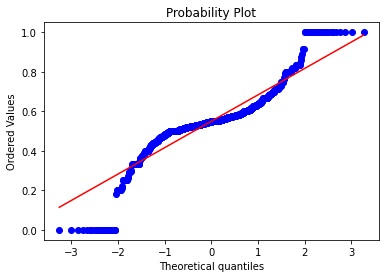

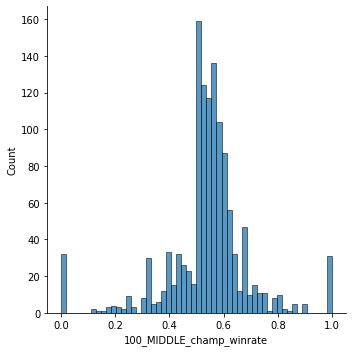

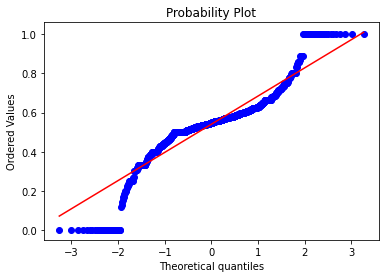

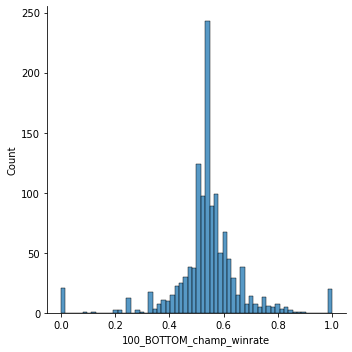

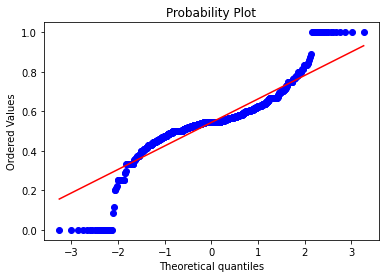

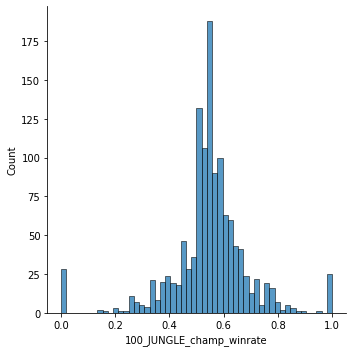

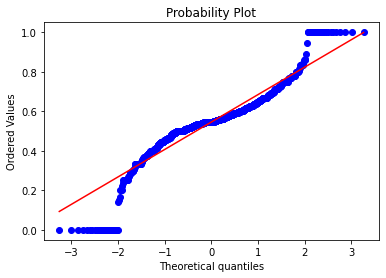

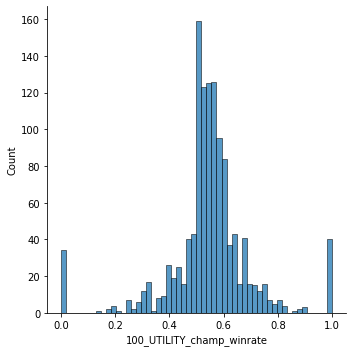

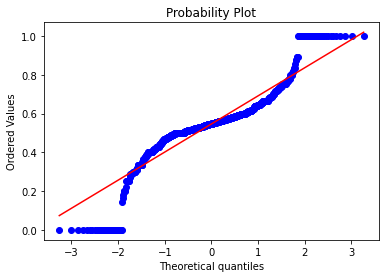

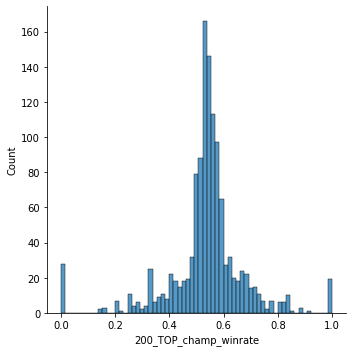

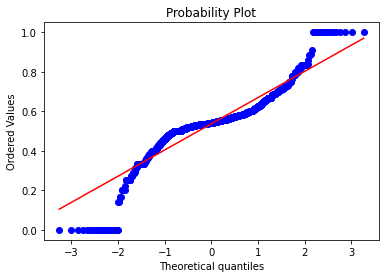

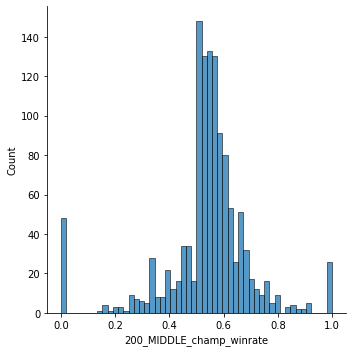

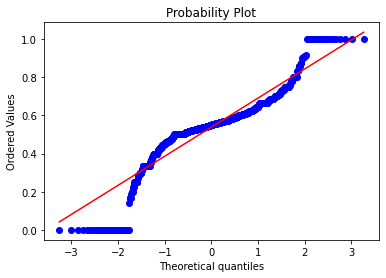

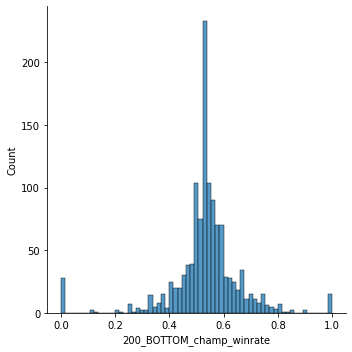

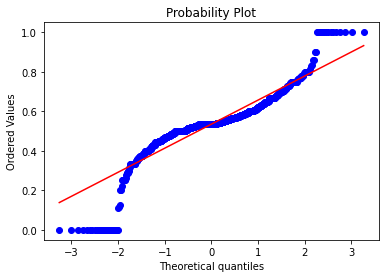

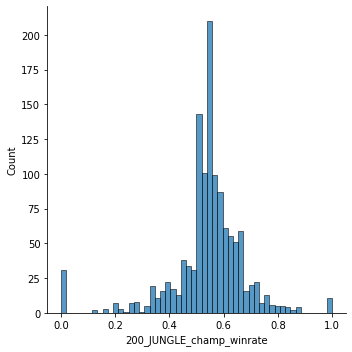

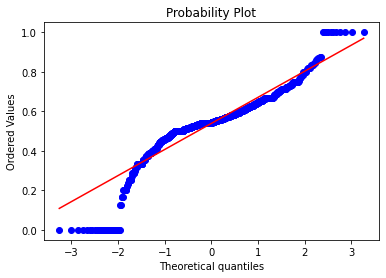

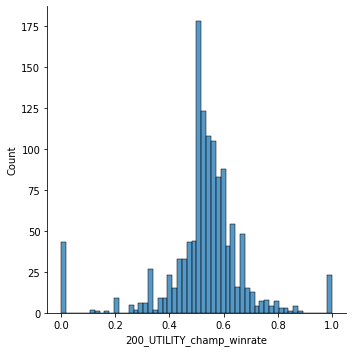

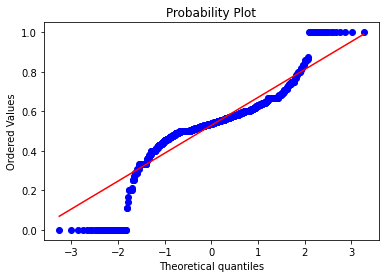

In [ ]:
for team in ["100", "200"]:
  for role in ["TOP", "MIDDLE", "BOTTOM", "JUNGLE", "UTILITY"]:
    var = team + "_" + role + "_champ_winrate"
    sns.displot(df[var])
    fig = plt.figure() # creates a new figure
    res = stats.probplot(df[var], plot=plt)

In [ ]:
var = df["100_TOP_champ_winrate"]
print("Skewness:", var.skew())
print("Kurtosis:", var.kurt())

Skewness: -0.4091123609594853
Kurtosis: 4.765411664861839


So this one seems negatively skewed, and has high kurtosis, meaning that tails are populated. I will experiment with transformations now.

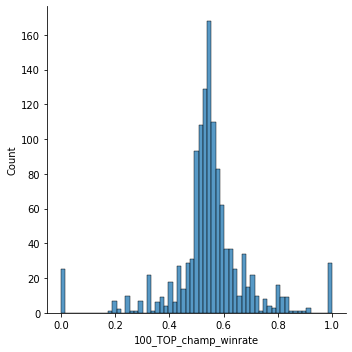

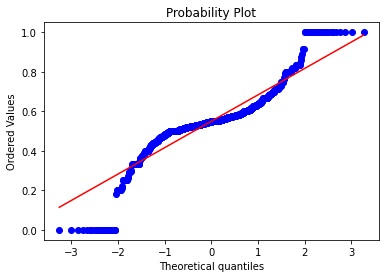

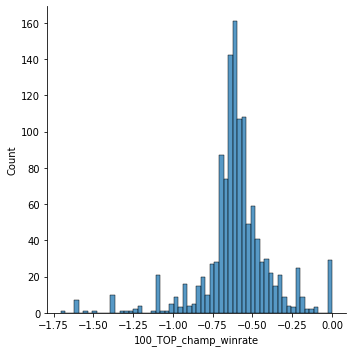

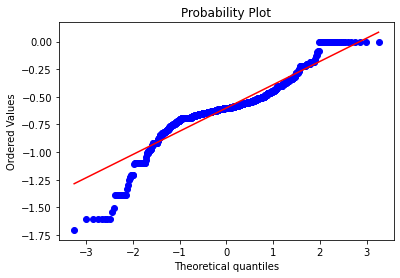

In [ ]:
no_zeroes = df[df["100_TOP_champ_winrate"] > 0]
logged_example = np.log(no_zeroes["100_TOP_champ_winrate"])
# logged_example = np.sqrt(df["100_TOP_champ_winrate"])
# tmp = 1/(df["100_TOP_champ_winrate"] + 1)
# logged_example = np.log1p(df["100_TOP_champ_winrate"]*1000)
sns.displot(df["100_TOP_champ_winrate"])
fig = plt.figure() # creates a new figure
res = stats.probplot(df["100_TOP_champ_winrate"], plot=plt)
sns.displot(logged_example)
fig = plt.figure() # creates a new figure
res = stats.probplot(logged_example, plot=plt)

In [ ]:
var = logged_example
print("type", type(var))
print("Skewness:", var.skew())
print("Kurtosis:", var.kurt())

type <class 'pandas.core.series.Series'>
Skewness: -0.8335365789853033
Kurtosis: 4.578403118004994


In [ ]:
from scipy.stats import boxcox

In [ ]:
no_zeroes = df[df["100_TOP_champ_winrate"] > 0]
no_zeroes = no_zeroes["100_TOP_champ_winrate"]
yes_zeroes = df[df["100_TOP_champ_winrate"] <= 0]
yes_zeroes = yes_zeroes["100_TOP_champ_winrate"]

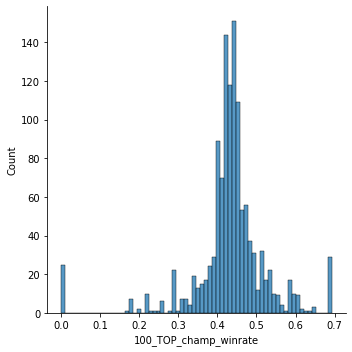

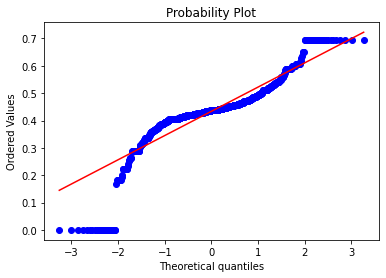

In [ ]:
var = no_zeroes
# bcx_target, lam = boxcox(var)

# print("lambda:", str(lam))

adjusted_var = np.log1p(var)

# lam is the best lambda for the distribution

var = pd.concat([pd.Series(adjusted_var), yes_zeroes])

sns.displot(var)
fig = plt.figure() # creates a new figure
res = stats.probplot(var, plot=plt)

# LP

While other variables typically range 0-1, or have a low range(as they represent some sort of ratio), LP can go to the thousands. I thought that applying a transformation to this variable might help, so I tried a few.

None of them helped me achieve normality, but later I decided to use the log1p transformation to bring the scale of the variable closer to that of the others.

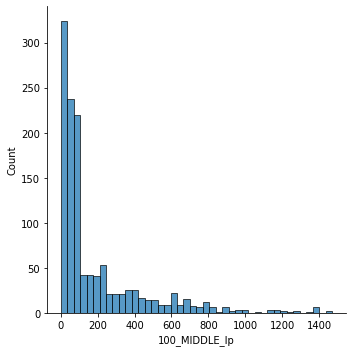

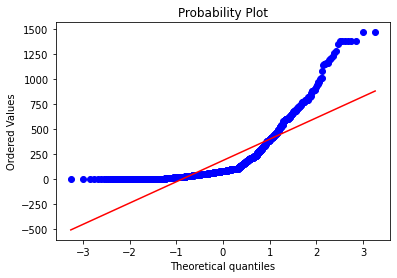

In [ ]:
var = df["100_MIDDLE_lp"]

sns.displot(var)
fig = plt.figure() # creates a new figure
res = stats.probplot(var, plot=plt)

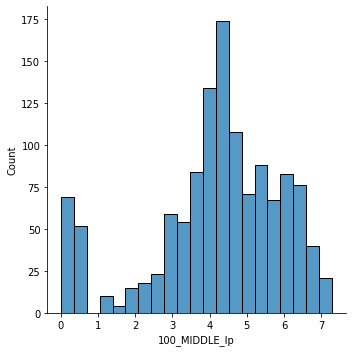

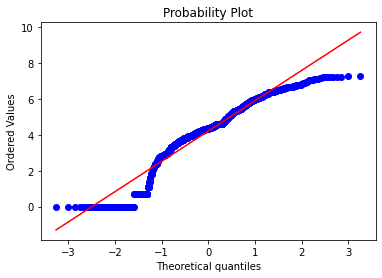

In [ ]:
# Log transformations are typically good for skewed variables, so I'll try that.

var = np.log1p(df["100_MIDDLE_lp"])

sns.displot(var)
fig = plt.figure() # creates a new figure
res = stats.probplot(var, plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


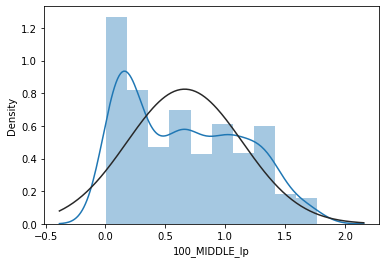

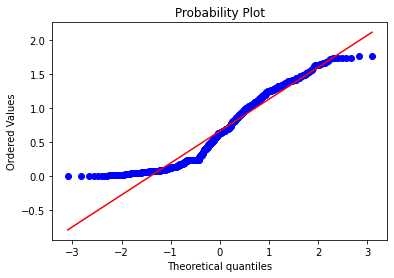

In [ ]:
var = np.log1p(df["100_MIDDLE_lp"])
var = (var - var.mean())/var.std()
var = var[var > 0]
sns.distplot(var, fit=norm)
fig = plt.figure() # creates a new figure
res = stats.probplot(var, plot=plt)

# Further Data Wrangling/Processing

Finally, I decided to proceed with the basic data wrangling that I did in my previous notebook. I will research cross-validation and ensemble learning(which is already achieved through the Random Forst Classifier, I believe) for now.

In [ ]:
# REMOVE ALL OBJECT DTYPES

object_type = df.dtypes == object
indexes_to_drop = object_type[object_type == True].index
df.drop(indexes_to_drop, axis=1, inplace=True)

In [ ]:
# CREATE TRAINING AND TESTING SETS

msk = np.random.rand(len(df)) < 0.7
train = df[msk]
test = df[~msk]
print(len(test), len(train))

357 893


In [ ]:
# GET X AND Y

train_x = train.drop("winning_team", axis=1)
train_y = train["winning_team"]

test_x = test.drop("winning_team", axis=1)
test_y = test["winning_team"]

# Models/k-fold cross validation

Here, I tried fine tuning my Random Forest Classification model, while using cross-validation to better evaluate the accuracy of each model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None)

random_state = 7
n_estimators = 100

model = RandomForestClassifier(random_state=random_state, n_estimators = n_estimators)

result = cross_val_score(model , train_x, train_y, cv = kf)

print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.7928818027744649


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None)

random_state = 7
n_estimators = 100

model = RandomForestClassifier(random_state=random_state, criterion="entropy", n_estimators = n_estimators)

result = cross_val_score(model , train_x, train_y, cv = kf)

print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.7985123344422823


In [ ]:
# TRYING LESS VARIABLES

def get_all_vars(to_append):
  lst = []
  for team in ["100", "200"]:
    for role in ["TOP", "MIDDLE", "BOTTOM", "JUNGLE", "UTILITY"]:
      lst.append(team + "_" + role + "_" + to_append)
  return lst

vars = get_all_vars("champ_winrate") + get_all_vars("wr") + get_all_vars("hotstreak") + get_all_vars("avg_kda") + get_all_vars("lp") + get_all_vars("role_wr")

train_x_tmp = train_x[vars]

I decided to try applying a simple transformation to the "lp" variables

In [ ]:
print(train_x_tmp["100_MIDDLE_lp"].mean(), train_x_tmp["100_MIDDLE_lp"].max(), train_x_tmp["100_MIDDLE_lp"].min())

189.14669652855542 1470 0


In [ ]:
tmp_var = np.log10(train_x_tmp["100_MIDDLE_lp"] + 1)
print(tmp_var.mean(), tmp_var.max(), tmp_var.min())

1.8421416986690444 3.16761267272753 0.0


In [ ]:
train_x_tmp2 = train_x_tmp.copy()
for variable in get_all_vars("lp"):
  train_x_tmp2[variable] = np.log1p(train_x_tmp2[variable])
print(train_x_tmp2["100_MIDDLE_lp"].mean(), train_x_tmp2["100_MIDDLE_lp"].max(), train_x_tmp2["100_MIDDLE_lp"].min())

4.241688014538061 7.293697720601438 0.0


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None)
set_to_train_on = train_x_tmp2

random_state = 7
n_estimators = 150
criterion="entropy"
min_samples_leaf=1  # this seems to make thins a bit better, higher numbers > lower score
min_samples_split=2  # lower numbers didn't do anything, higher numbers seem to decrease the score

model = RandomForestClassifier(random_state=random_state, 
                               criterion=criterion, 
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators = n_estimators)

result = cross_val_score(model , set_to_train_on, train_y, cv = kf)

print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.8141359613332495


### Description of RandomForestClassifier Parameters
 - random_state is basically like setting a seed
 - n_estimators is the number of trees in the forest
 - criterion is gini(impurity) or entropy
 - min_samples_leaf is minimum number of samples in a leaf(default 1)
 - min_samples_split is min samples required to do a split(default 2)

## My Process(Things that I've tried)

Selecting highest correlated variables and adding more estimators allowed the accuracy to reach over 80%. Some of the other variables were poorly processed, so omitting them increased the accuracy of the model.

Changing min_samples_leaf and min_samples_split didn't change the cross validation score by much. Making them too high decreased the cross validation score, probably due to underfitting. This suggests that the model is not overfitting too much, which makes sense, as the dataset is quite small.

Logging LP added around .2 to the cross-validation score(my reasoning was that the other variables typically ranged from 0 to 1, but lp would average 100, so I tried to scale LP down).

## Things to try in the future

Try adding more variables to be considered by the model, by cleaning more variables.

Get more data(working on that currently)

Make a new variable called ranked_wr or something that is equal to wins/(wins+losses), adjust missing and outlier champ_wr, wr, etc. and look at the correlation matrix again.

*(basically take the other variables and use them to create more descriptive ones)*


# Recap

In this notebook, I've tried:

 - Cross Validation
 - Tuning my model
 - Logistic Regression, instead of classification model (I've seen other league predictors created using logistic regression, so I will research it later and try it out.)

## Summary of my research on cross-validation

Cross validation is basically just a better way of estimating how your model will perform on unseen data. You separate the data into n parts, train models on n-1 parts, and validate it on the final part. You train multiple models, each using one of the parts as the "validation set." You can then report the accuracy of each model, find the average accuracy, etc.

This allows you to better fine-tune models and stuff, resulting in a better model. Therefore, we should tune the model while we cross-validate.

Then, you train the final model on all of the data, and then test it.